## Environment

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
a = np.random.multinomial(1,[1/5.]*5)
print(a)
print(np.argmax(a))

[0 1 0 0 0]
1


In [ ]:
class Environment():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost,phase):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling
    self.phase = phase                                              # phase vector (size: 365)
    self.day = 0                                                    # day counter

  # daily rewards
  def bidding_round(self, pulled_bid):
    clicks = int(np.random.normal(self.average_number_of_clicks(self.bids[pulled_bid]),self.noise_clicks))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost(self.bids[pulled_bid]),self.noise_cost)                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0

    return reward_click, reward_cost

  def pricing_round(self, pulled_price):
    reward_price = np.random.binomial(1,self.probabilities[self.phase[self.day],pulled_price])                         # number of people that buy once they clicked
    return reward_price

  def day_round(self):
    self.day += 1

## Pricing

In [ ]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [ ]:
class Exp3_Pricing_Learner(Learner):
  def __init__(self,n_arms,prices, gamma=0.2):
    super().__init__(n_arms)                    # number of prices
    self.gamma = gamma                          # exploration parameter
    self.prices = prices                        # prices (array)
    self.weights = np.ones(len(prices))         # weights parameter
    self.p = np.array([(1-self.gamma)*self.weights[i]/np.sum(self.weights)+self.gamma/self.n_arms for i in range(self.n_arms)])

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    idx = np.random.choice([0,1,2,3,4], p=self.p)
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    est_reward = reward*self.prices[pulled_arm]/self.p[pulled_arm]
    self.weights[pulled_arm] = self.weights[pulled_arm]*np.exp(self.gamma*est_reward/len(self.prices))
    self.p = np.array([(1-self.gamma)*self.weights[i]/np.sum(self.weights)+self.gamma/self.n_arms for i in range(self.n_arms)])

  def debug(self):
    print(self.p)
    print(self.weights)

## Simulation

In [ ]:
# generic
T = 365                                # horizon of experiment
n_experiments = 100                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experimentsQ

In [ ]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([[0.36,0.3,0.257,0.313,0.2],
              [0.5,0.3,0.257,0.225,0.2],
              [0.36,0.3,0.257,0.225,0.278],
              [0.36,0.416,0.257,0.225,0.2],
              [0.36,0.3,0.357,0.225,0.2]])            # bernoulli distributions for the reward functions

opt_rate = np.array([])
for i in range(p.shape[0]):
  opt = p[i,:][np.argmax(p[i,:]*prices)]
  opt_rate = np.append(opt_rate,opt)
  print("Phase " + str(i+1) + ":")
  print("idx: " + str(np.argmax(p[i,:]*prices)) + "  price: " + str(prices[np.argmax(p[i,:]*prices)]) + "  rate: " + str(opt) + "  price*rate: " + str(opt*prices[np.argmax(p[i,:]*prices)]))
  print("")

Phase 1:
idx: 3  price: 8  rate: 0.313  price*rate: 2.504

Phase 2:
idx: 0  price: 5  rate: 0.5  price*rate: 2.5

Phase 3:
idx: 4  price: 9  rate: 0.278  price*rate: 2.5020000000000002

Phase 4:
idx: 1  price: 6  rate: 0.416  price*rate: 2.496

Phase 5:
idx: 2  price: 7  rate: 0.357  price*rate: 2.4989999999999997



Advertising (optimal bid):
idx: 64  bid: 0.6464646464646465  clicks-costs: 6.719849791582364


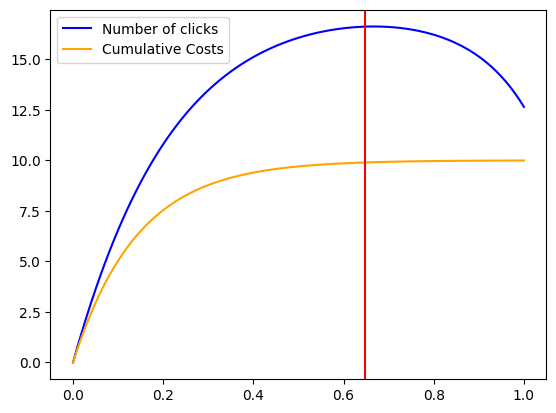

In [ ]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = 3
sigma_costs = 3
def clicks(x):
  return 20 * (1.0 - np.exp(-4*x+3*x**3))
def costs(x):
  return 10 * (1.0 - np.exp(-7*x))
opt_bid_ind = np.argmax(clicks(bids)-costs(bids))
plt.plot(bids,clicks(bids),'blue',bids,costs(bids),'orange')
plt.legend(["Number of clicks", "Cumulative Costs"])
plt.axvline(bids[opt_bid_ind],c='red')
print("Advertising (optimal bid):")
print("idx: " + str(opt_bid_ind) + "  bid: " + str(bids[opt_bid_ind]) + "  clicks-costs: " + str(clicks(bids[opt_bid_ind])-costs(bids[opt_bid_ind])))

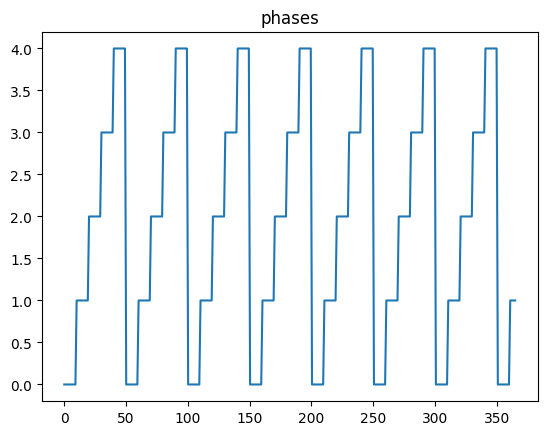

In [ ]:
# Non stationarity: cyclic frequent changes
phase = []
change_rate = 10
ind = -1
for i in range(365):
  if not i%change_rate:
    ind = ind+1
    a = ind%5
  phase.append(a)

t = np.linspace(0,365,365)
plt.plot(t,phase)
plt.title("phases")

opt=np.array([])
for i in phase:
  opt = np.append(opt,opt_rate[i]*prices[np.argmax(p[i,:]*prices)]*clicks(bids[opt_bid_ind]) - costs(bids[opt_bid_ind]))


## Known advertising

In [ ]:
# experiments
n_experiments = 1
gamma = 0.25

exp3_rewards_per_experiment = []
phase_tracker_per_experiment = []

for e in tqdm(range(0,n_experiments)):  # cycle on experiments
  env = Environment(n_arms = n_prices,
                    probabilities = p,
                    bids = bids,
                    average_number_of_clicks = clicks,
                    average_cum_daily_cost = costs,
                    noise_clicks = sigma_clicks,
                    noise_cost = sigma_costs,
                    phase = phase)

  exp3_learner = Exp3_Pricing_Learner(n_arms = n_prices,
                                      prices = prices,
                                      gamma=gamma)


  exp3_collected_costs = np.array([])
  exp3_daily_pricing_reward = np.array([])

  for t in range(0,T):  # cycle on time horizon

    # Exp3
    pulled_bid = opt_bid_ind # 64
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    exp3_collected_costs = np.append(exp3_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = exp3_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price)
      exp3_learner.update(pulled_price, reward_price)
      #exp3_learner.debug()
    print(env.phase[env.day])
    print(env.probabilities[env.phase[env.day]])


    exp3_daily_pricing_reward = np.append(exp3_daily_pricing_reward,(reward_click>0)*np.sum(exp3_learner.collected_rewards[-reward_click:]))
    env.day_round()
  #exp3_learner.debug()
  exp3_rewards_per_experiment.append(exp3_daily_pricing_reward - exp3_collected_costs)

  0%|          | 0/1 [00:00<?, ?it/s]

0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
2
[0.36  0.3   0.257 0.225 0.278]
2
[0.36  0.3   0.257 0.225 0.278]
2
[0.36  0.3   0.257 0.225 0.278]
2
[0.36  0.3   0.257 0.225 0.278]
2
[0.36  0.3   0.257 0.225 0.278]
2
[0.36  0.3   0.257 0.225 0.278]
2
[0.36  0.3   0.257 0.225 0.278]
2
[0.36  0.3   0.257 0.225 0.278]
2
[0.36  0.3   0.257 0.225 0.278]
2
[0.36  0.3  

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


[0.36  0.3   0.357 0.225 0.2  ]
4
[0.36  0.3   0.357 0.225 0.2  ]
4
[0.36  0.3   0.357 0.225 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
0
[0.36  0.3   0.257 0.313 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]
1
[0.5   0.3   0.257 0.225 0.2  ]


In [ ]:
for i in range(len(prices)):
  print(len(exp3_learner.rewards_per_arm[i]))

316
306
3607
788
939


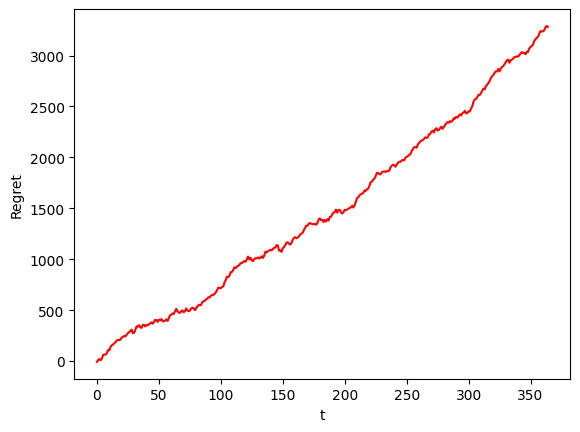

In [ ]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - exp3_rewards_per_experiment, axis = 0)), 'r')